In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [233]:
path="D:/Programmers/datasets/"
dataset0_train_path = "D:/Programmers/datasets/dataset0/dataset0/train/"
dataset0_test_path = "D:/Programmers/datasets/dataset0/dataset0/test/"
dataset1_train_path = "D:/Programmers/datasets/dataset1/dataset1/train/"
dataset1_test_path = "D:/Programmers/datasets/dataset1/dataset1/test/"
submission = pd.read_csv("D:/Programmers/submission_sample.csv")

In [90]:
dataset0_classes = os.listdir(dataset0_train_path)
dataset0_label_encoder = LabelEncoder()

dataset0_label_encoder.fit(dataset0_classes)
print(dataset0_label_encoder.classes_)

dataset1_classes = os.listdir(dataset1_train_path)
dataset1_label_encoder = LabelEncoder()

dataset1_label_encoder.fit(dataset1_classes)
print(dataset1_label_encoder.classes_)

['class0' 'class1' 'class11' 'class12' 'class13' 'class14' 'class15'
 'class2' 'class3' 'class4' 'class5' 'class6' 'class7' 'class8' 'class9']
['class0' 'class1' 'class10' 'class2' 'class3' 'class4' 'class5' 'class6'
 'class7' 'class8' 'class9']


In [200]:
def create_dataset(dataset_dir):
  X, y = [], []
  labels = os.listdir(dataset_dir)
  for label in labels:
    file_list = os.listdir(dataset_dir + label + '/')
    for f in file_list:
      temp = pd.read_csv(dataset_dir + label + '/' + f)
      X.append(tf.convert_to_tensor(temp))
      y.append(label)
  X = keras.preprocessing.sequence.pad_sequences(X, padding="post")
  return X, y

In [194]:
#       X.append(temp.to_numpy().reshape(6, -1))

In [201]:
dataset0_X_train, dataset0_y_train = create_dataset(dataset0_train_path)
dataset0_y_train = dataset0_label_encoder.transform(dataset0_y_train)

dataset0_X_test, dataset0_y_test = create_dataset(dataset0_test_path)
dataset0_y_test = dataset0_label_encoder.transform(dataset0_y_test)

In [293]:
dataset1_X_train, dataset1_y_train = create_dataset(dataset1_train_path)
dataset1_y_train = dataset1_label_encoder.transform(dataset1_y_train)

In [203]:
# X_train = np.array(dataset0_X_train)
# y_train = np.array(dataset0_y_train)
# X_valid = np.array(dataset0_X_test)
# y_valid = np.array(dataset0_y_test)

In [207]:
dataset1_test_X = []
test_list = os.listdir(dataset1_test_path)
for f in test_list:
  temp = pd.read_csv(dataset1_test_path + f)
  dataset1_test_X.append(tf.convert_to_tensor(temp))
dataset1_test_X = keras.preprocessing.sequence.pad_sequences(dataset1_test_X, padding="post")

# Make model

In [220]:
set(dataset0_y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [230]:
Input = keras.Input(shape=[None, 6])
x = keras.layers.LSTM(20, return_sequences=True)(Input)
x = keras.layers.LSTM(20)(x)
output = keras.layers.Dense(15, activation="softmax")(x)

model = keras.Model(inputs = Input, outputs=output)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
model.fit(dataset0_X_train, dataset0_y_train, validation_data=(dataset0_X_test, dataset0_y_test), epochs=10)

Epoch 1/10
437/437 [==============================] - 20s 40ms/step - loss: 1.8052 - accuracy: 0.4046 - val_loss: 1.6583 - val_accuracy: 0.4272
Epoch 2/10
437/437 [==============================] - 17s 38ms/step - loss: 1.4285 - accuracy: 0.5144 - val_loss: 1.4842 - val_accuracy: 0.4705
Epoch 3/10
437/437 [==============================] - 17s 38ms/step - loss: 1.3361 - accuracy: 0.5497 - val_loss: 1.4770 - val_accuracy: 0.5168
Epoch 4/10
437/437 [==============================] - 17s 38ms/step - loss: 1.4760 - accuracy: 0.5030 - val_loss: 1.6060 - val_accuracy: 0.4595
Epoch 5/10
437/437 [==============================] - 17s 38ms/step - loss: 1.3622 - accuracy: 0.5485 - val_loss: 1.4225 - val_accuracy: 0.5200
Epoch 6/10
437/437 [==============================] - 17s 38ms/step - loss: 1.2627 - accuracy: 0.5671 - val_loss: 1.3919 - val_accuracy: 0.5286
Epoch 7/10
437/437 [==============================] - 17s 39ms/step - loss: 1.1830 - accuracy: 0.5980 - val_loss: 1.4001 - val_accuracy:

In [258]:
submission["label"] = dataset0_label_encoder.inverse_transform(np.argmax(model.predict(dataset1_test_X), axis=-1))
submission.to_csv("./base.csv", index=None)

데이터 전처리, 라벨값 변환, 모델 출력까지의 과정을 거쳐 제출 결과: 4.59
이후 추가적인 모델 튜닝 진행

# Model Tuning

In [275]:
def make_model(iter = 0,node= 0):
    Input = keras.Input(shape=[None, 6])
    for _ in range(iter):
        x = keras.layers.LSTM(node, return_sequences=True)(Input)
    if iter==0:
        x = keras.layers.LSTM(node)(Input)
    else:
        x = keras.layers.LSTM(node)(x)
    output = keras.layers.Dense(15, activation="softmax")(x)

    model = keras.Model(inputs = Input, outputs=output)
    model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
    return model

In [276]:
es = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [277]:
hist_list=[]
name_list=[]
for i in [0, 1, 2]:
    for j in [10, 15, 20]:
        model = make_model(i, j)
        hist_list.append(model.fit(dataset0_X_train, dataset0_y_train,
                                   validation_data=(dataset0_X_test, dataset0_y_test), epochs=30, callbacks=[es]))
        name_list.append([i, j])

Epoch 1/30
437/437 [==============================] - 11s 22ms/step - loss: 2.2134 - accuracy: 0.2818 - val_loss: 1.9519 - val_accuracy: 0.3776
Epoch 2/30
437/437 [==============================] - 9s 21ms/step - loss: 1.7711 - accuracy: 0.4443 - val_loss: 1.6191 - val_accuracy: 0.5005
Epoch 3/30
437/437 [==============================] - 9s 21ms/step - loss: 1.4451 - accuracy: 0.5648 - val_loss: 1.3909 - val_accuracy: 0.5741
Epoch 4/30
437/437 [==============================] - 9s 21ms/step - loss: 1.2916 - accuracy: 0.6050 - val_loss: 1.3120 - val_accuracy: 0.5882
Epoch 5/30
437/437 [==============================] - 9s 22ms/step - loss: 1.2084 - accuracy: 0.6165 - val_loss: 1.2616 - val_accuracy: 0.5808
Epoch 6/30
437/437 [==============================] - 10s 22ms/step - loss: 1.1376 - accuracy: 0.6228 - val_loss: 1.2710 - val_accuracy: 0.5739
Epoch 7/30
437/437 [==============================] - 10s 22ms/step - loss: 1.0695 - accuracy: 0.6394 - val_loss: 1.1722 - val_accuracy: 0.5

437/437 [==============================] - 10s 22ms/step - loss: 1.0780 - accuracy: 0.6462 - val_loss: 1.2566 - val_accuracy: 0.5822
Epoch 7/30
437/437 [==============================] - 10s 23ms/step - loss: 1.0275 - accuracy: 0.6558 - val_loss: 1.2348 - val_accuracy: 0.5864
Epoch 8/30
437/437 [==============================] - 10s 22ms/step - loss: 1.0160 - accuracy: 0.6589 - val_loss: 1.2308 - val_accuracy: 0.5872
Epoch 9/30
437/437 [==============================] - 10s 22ms/step - loss: 1.0033 - accuracy: 0.6644 - val_loss: 1.1635 - val_accuracy: 0.6110
Epoch 10/30
437/437 [==============================] - 10s 22ms/step - loss: 0.9792 - accuracy: 0.6656 - val_loss: 1.1961 - val_accuracy: 0.6089
Epoch 11/30
437/437 [==============================] - 10s 22ms/step - loss: 0.9496 - accuracy: 0.6795 - val_loss: 1.1397 - val_accuracy: 0.6159
Epoch 12/30
437/437 [==============================] - 10s 22ms/step - loss: 0.9416 - accuracy: 0.6849 - val_loss: 1.1250 - val_accuracy: 0.6168


Epoch 7/30
437/437 [==============================] - 17s 39ms/step - loss: 1.1204 - accuracy: 0.6334 - val_loss: 1.3151 - val_accuracy: 0.5849
Epoch 8/30
437/437 [==============================] - 17s 39ms/step - loss: 1.0660 - accuracy: 0.6459 - val_loss: 1.2993 - val_accuracy: 0.5786
Epoch 9/30
437/437 [==============================] - 17s 39ms/step - loss: 1.1807 - accuracy: 0.6089 - val_loss: 1.4975 - val_accuracy: 0.5108
Epoch 10/30
437/437 [==============================] - 17s 39ms/step - loss: 1.2099 - accuracy: 0.5727 - val_loss: 1.4078 - val_accuracy: 0.4949
Epoch 1/30
437/437 [==============================] - 21s 42ms/step - loss: 2.0649 - accuracy: 0.3351 - val_loss: 1.8200 - val_accuracy: 0.4052
Epoch 2/30
437/437 [==============================] - 17s 40ms/step - loss: 1.5639 - accuracy: 0.5216 - val_loss: 1.6589 - val_accuracy: 0.4651
Epoch 3/30
437/437 [==============================] - 18s 40ms/step - loss: 1.3677 - accuracy: 0.5900 - val_loss: 1.4483 - val_accuracy

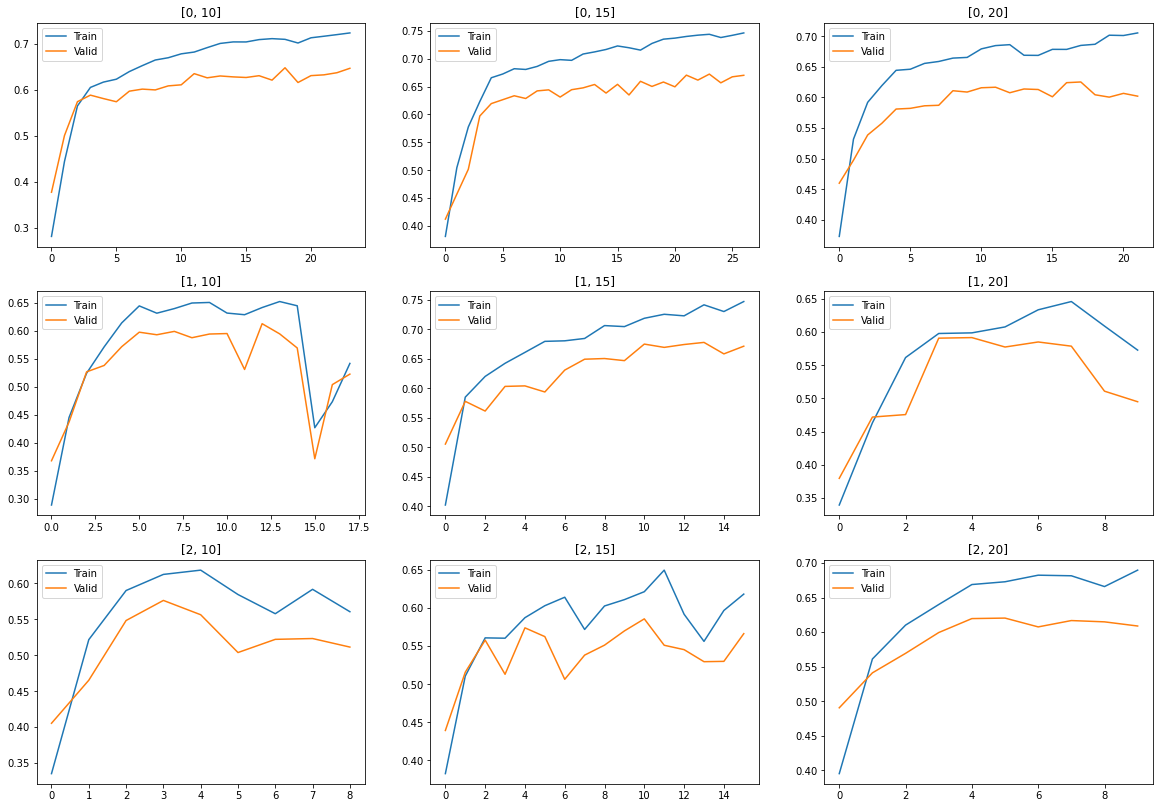

In [280]:
fig = plt.figure(figsize=(20, 14))
for i in range(1, 10):
    ax = plt.subplot(3, 3, i)
#     plt.ylim(0.5, 0.8)
    plt.plot(hist_list[i-1].history["accuracy"], label="Train")    
    plt.plot(hist_list[i-1].history["val_accuracy"], label="Valid")
    plt.title(name_list[i-1])
    plt.legend()

In [281]:
for i in range(9):
    print(hist_list[i].history["val_accuracy"][-1])

0.6464515924453735
0.6701075434684753
0.602150559425354
0.5227240324020386
0.671397864818573
0.4949103891849518
0.5112544894218445
0.5660215020179749
0.6087455153465271


In [284]:
def make_model(iter = 0,node= 0):
    Input = keras.Input(shape=[None, 6])
    for _ in range(iter):
        x = keras.layers.LSTM(node, return_sequences=True)(Input)
    if iter==0:
        x = keras.layers.LSTM(node)(Input)
    else:
        x = keras.layers.LSTM(node)(x)
    output = keras.layers.Dense(15, activation="softmax")(x)

    model = keras.Model(inputs = Input, outputs=output)
    model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
    return model

In [285]:
es = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [286]:
model = make_model(1, 15)
hist_list.append(model.fit(dataset0_X_train, dataset0_y_train,
                           validation_data=(dataset0_X_test, dataset0_y_test), epochs=100, callbacks=[es]))

Epoch 1/100
437/437 [==============================] - 21s 42ms/step - loss: 1.8025 - accuracy: 0.3991 - val_loss: 1.6881 - val_accuracy: 0.4806
Epoch 2/100
437/437 [==============================] - 18s 40ms/step - loss: 1.3988 - accuracy: 0.5500 - val_loss: 1.4692 - val_accuracy: 0.5206
Epoch 3/100
437/437 [==============================] - 18s 41ms/step - loss: 1.3234 - accuracy: 0.5578 - val_loss: 1.3828 - val_accuracy: 0.5240
Epoch 4/100
437/437 [==============================] - 18s 40ms/step - loss: 1.2248 - accuracy: 0.5940 - val_loss: 1.3007 - val_accuracy: 0.5511
Epoch 5/100
437/437 [==============================] - 18s 41ms/step - loss: 1.1364 - accuracy: 0.6106 - val_loss: 1.5182 - val_accuracy: 0.4853
Epoch 6/100
437/437 [==============================] - 18s 40ms/step - loss: 1.1000 - accuracy: 0.6187 - val_loss: 1.2658 - val_accuracy: 0.5667
Epoch 7/100
437/437 [==============================] - 18s 40ms/step - loss: 1.0685 - accuracy: 0.6272 - val_loss: 1.2212 - val_ac

In [287]:
model.save("./model.h5")

In [342]:
model = keras.models.load_model("./model.h5")

In [355]:
test_model = keras.models.Sequential(model.layers[:-1])
test_model.add(keras.layers.Dense(11, activation="softmax"))
for layer in test_model.layers[:-1]:
    layer.trainable=False

In [356]:
es = keras.callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

In [357]:
test_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
test_model.fit(dataset1_X_train, dataset1_y_train, epochs=5, callbacks=[es])

Epoch 1/5
55/55 [==============================] - 4s 20ms/step - loss: 2.6039 - accuracy: 0.0531
Epoch 2/5
55/55 [==============================] - 1s 19ms/step - loss: 2.2316 - accuracy: 0.1349
Epoch 3/5
55/55 [==============================] - 1s 19ms/step - loss: 1.9642 - accuracy: 0.2194
Epoch 4/5
55/55 [==============================] - 1s 19ms/step - loss: 1.7717 - accuracy: 0.3897
Epoch 5/5
55/55 [==============================] - 1s 19ms/step - loss: 1.6346 - accuracy: 0.4577


In [358]:
for layer in test_model.layers[:-1]:
    layer.trainable=True

In [359]:
es = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [361]:
test_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
test_model.fit(dataset1_X_train, dataset1_y_train,validation_split=0.2, epochs=30, callbacks=[es])

Epoch 1/30
44/44 [==============================] - 5s 56ms/step - loss: 1.3138 - accuracy: 0.4664 - val_loss: 2.4297 - val_accuracy: 0.3686
Epoch 2/30
44/44 [==============================] - 2s 40ms/step - loss: 1.1442 - accuracy: 0.5171 - val_loss: 2.5846 - val_accuracy: 0.3600
Epoch 3/30
44/44 [==============================] - 2s 41ms/step - loss: 1.0134 - accuracy: 0.5814 - val_loss: 2.6506 - val_accuracy: 0.4057
Epoch 4/30
44/44 [==============================] - 2s 41ms/step - loss: 0.9402 - accuracy: 0.6729 - val_loss: 2.6980 - val_accuracy: 0.4543
Epoch 5/30
44/44 [==============================] - 2s 41ms/step - loss: 0.9826 - accuracy: 0.6386 - val_loss: 2.7313 - val_accuracy: 0.4486
Epoch 6/30
44/44 [==============================] - 2s 40ms/step - loss: 1.0019 - accuracy: 0.5964 - val_loss: 2.8472 - val_accuracy: 0.3943


In [362]:
submission["label"] = dataset1_label_encoder.inverse_transform(np.argmax(test_model.predict(dataset1_test_X), axis=-1))
submission.to_csv("./submission.csv", index=None)